In [2]:
from Programlib import Program, Instruction, CASES
import Selection
import random
import pickle
import math
MIN_LENGTH = 1
MAX_LENGTH = 128
Selection.set_max_length(128)
Selection.MAX_LENGTH

128

In [2]:
def rand():
    """ Generates a Random Program """
    random_program = Program(IS=['Add', 'Sub', 'Mul', 'Div', 'Mean', 'Copy', 'Sqrt'])
    return random_program

def I(program, inp):
    """ Runs 'program' on input inp. Clips the return value to lie in [-1,1] as per the HW instructions """
    program.reset()
    program._set_input(inp)
    return_val = program.execute()
    # if return_val > 1:
    #     return 1
    # if return_val < -1:
    #     return -1
    return return_val

def f(program, gen, cases=CASES):
    """ Returns the sum of the squared error on the fitness cases for evaluating sin """
    F1_AMELIORATION = 2_500
    fitness = 0
    dif     = 0
    outs    = []
    fitness_1 = 0
    fitness_2 = 0
    out_counts = {}
    for i in range(len(cases)):
        tv = math.sin(cases[i])     #true value of sin for the fitness case
        rv = I(program, cases[i])   #return value of the program evaluated on the fitness case
        outs.append(rv) 
        fitness_1 += math.sqrt((rv-tv)**2)
        for out in outs:
            if out in out_counts.keys():
                out_counts[out] += 1
            else:
                out_counts[out] = 1
        for out_count in out_counts.keys():
            if out_counts[out_count] > 1:
                fitness_2 += out_counts[out_count]**2
    fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 
    return fitness

def f1(program, cases=CASES):
    F1_AMELIORATION = 2_500
    fitness = 0
    dif     = 0
    outs    = []
    fitness_1 = 0
    fitness_2 = 0
    out_counts = {}
    for i in range(len(cases)):
        tv = math.sin(cases[i])     #true value of sin for the fitness case
        rv = I(program, cases[i])   #return value of the program evaluated on the fitness case
        outs.append(rv) 
        try:
            fitness_1 += math.sqrt((rv-tv)**2)# + 0.002*len(program.INST)
        except OverflowError:
            fitness_1 = math.inf
    
    #     for out in outs:
    #         if out in out_counts.keys():
    #             out_counts[out] += 1
    #         else:
    #             out_counts[out] = 1
    #     for out_count in out_counts.keys():
    #         if out_counts[out_count] > 1:
    #             fitness_2 += out_counts[out_count]**2
    # fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 
    return fitness_1
    
    
def f2(program, generation=None, cases=CASES):
    F1_AMELIORATION = 2_500
    fitness = 0
    dif     = 0
    outs    = []
    fitness_1 = 0
    fitness_2 = 0
    out_counts = {}
    for i in range(len(cases)):
        #tv = math.sin(cases[i])     #true value of sin for the fitness case
        rv = I(program, cases[i])   #return value of the program evaluated on the fitness case
        outs.append(rv) 
        #fitness_1 += math.sqrt((rv-tv)**2)
    for out in outs:
        if out in out_counts.keys():
            out_counts[out] += 1
        else:
            out_counts[out] = 1
    for out_count in out_counts.keys():
        if out_counts[out_count] > 1:
            fitness_2 += out_counts[out_count]**2
    # fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 
    return fitness_2

def mut(program):
    #PROBABILITIES TO
    ADD_P = 0.0095   #Add a random instruction in a random location
    REM_P = 0.006   #Delete a random instruction
    NAM_P = 0.005   #Change the name of an instruction (and therefore its type)
    ARG_P = 0.005   #Change an argument of an instruction
    SWP_P = 0.005   #Swap two instructions
    
    if random.random() < ADD_P:  #Add instruction
        if (len(program.INST) < MAX_LENGTH):
            rand_inst = Instruction(len(program.WREG), len(program.CREG), instruction_set=program.IS)
            loc       = random.randint(0, len(program.INST))
            program.INST.insert(loc, rand_inst)
            
    if random.random() < REM_P:  #Remove instruction
        if (len(program.INST) > MIN_LENGTH):
            loc       = random.randint(0, len(program.INST)-1)
            program.INST.pop(loc)
            
    if random.random() < NAM_P:  #Change an instruction name
        if(len(program.INST) > 1):
            loc = random.randint(0, len(program.INST)-1)
            program.INST[loc]._set_name(random.choice(program.IS))
        
    if random.random() < ARG_P:   #Change argument to an instruction
        if(len(program.INST) > 1):
            inst_loc = random.randint(0, len(program.INST)-1)
            arg_loc  = random.randint(0,2)
            if arg_loc == 1:
                program.INST[inst_loc]._set_op1(random.randint(0, len(program.REG)))
            if arg_loc == 2:
                program.INST[inst_loc]._set_op2(random.randint(0, len(program.REG)))
            if arg_loc == 0:
                program.INST[inst_loc]._set_dest(random.randint(0, len(program.WREG)))
            
    if random.random() < SWP_P:   #Swap the index of two instructions
        if (len(program.INST) > 1):
            loc1 = random.randint(0, len(program.INST)-1)
            loc2 = random.randint(0, len(program.INST)-1)
            temp = program.INST[loc1]
            program.INST[loc1] = program.INST[loc2]
            program.INST[loc2] = temp
            
def XOver(prog1, prog2):
    """ Crossover Function chooses 2 random crossover points (one for each individual)
        Swaps the second part of program 2's instructions with the first part of program 1's instructions """
    #TODO: Make sure Xover cannot create programs that are too long!
    #Maybe determine the length of each program after loc1 and loc2 are selected and modify if one would be too long
    length_after_Xover_prog1 = MAX_LENGTH + 1
    length_after_Xover_prog2 = MAX_LENGTH + 1
    
    if ((len(prog1.INST) > 1) and (len(prog2.INST) > 1)):
        while(length_after_Xover_prog1 > MAX_LENGTH or length_after_Xover_prog2 > MAX_LENGTH):
            loc1 = random.randint(0, len(prog1.INST)-1)
            loc2 = random.randint(0, len(prog2.INST)-1)
            temp1 = prog1.INST[:loc1]
            temp2 = prog2.INST[loc2:]
            length_after_Xover_prog1 = len(temp2 + prog1.INST[loc1:])
            length_after_Xover_prog2 = len(prog2.INST[:loc2] + temp1)
        prog1.INST = temp2 + prog1.INST[loc1:]
        prog2.INST = prog2.INST[:loc2] + temp1
    

In [3]:
POP_SIZE     = 1500
XOVER_P      = 0.009
ELITE_K      = int(POP_SIZE*0.1)#50
population   = [Program(reg_init='z', IS=['Add', 'Sub', 'Mul', 'Div', 'Mean', 'Copy', \
                                 'Sqrt', 'Sqr', 'Max', 'Min', 'Exp', 'Log', 'Lt', 'Gte', \
                                 'Eq', 'Neq', 'And', 'Or', 'Not', 'If']) for i in range(POP_SIZE)] # Start with a population of 500 random programs
best_fitness = 10**100                     # Start this very high since even a random program will beat it
best_prog    = None                       # Keep track of the best program
tolerance    = 1                          # Stop searching when the best program has a fitness less than 1 (we want to minimize error)
generation   = 1

best_fitnesses_generation = []
avg_fitnesses_generation  = []

#TODO: Consider a fitness function that encourages putting DIFFERENT functions of the input in different registers. 10_000
#      is too big for a population and XOVER and mutation probabilities should be lowered.



logfile = open('log3.txt', 'w+')

while (generation < 3500):
    if (generation % 100 < 10):
        dumpfile='./saved_generations2/generation'+str(generation)+'.pkl'
        with open(dumpfile, 'wb+') as du:
            pickle.dump(population, du)
    print('Generation: ', generation)
    this_gen_fitness= []
    for individual in population:
        ind_fit = f1(individual, CASES)
        this_gen_fitness.append(ind_fit)
        if ind_fit < best_fitness:
            print('----------NEW BEST FITNESS---------------')
            print(ind_fit)
            print(individual)
            print('---------- EFFECTIVE PROGRAM ---------------')
            individual.print_effective_program()
            best_fitness = ind_fit
            best_prog    = individual
    best_fitnesses_generation.append(min(this_gen_fitness))
    avg_fitnesses_generation.append(sum(this_gen_fitness)/len(this_gen_fitness))
    logfile.write('-----------------GENERATION ' + str(generation) + '---------------------------\n')
    logfile.write("Fitnesses: [" + ", ".join(str(item) for item in this_gen_fitness) + "]\n")
    logfile.write('best fitness: ' +  str(best_fitnesses_generation[-1]) + "\n")
    logfile.write('avg fitnesses: ' +  str(avg_fitnesses_generation[-1]) + "\n")
    print('Best Fitness: ', best_fitnesses_generation[-1])
    print('Avg  Fitness: ', avg_fitnesses_generation[-1])
    elite = Selection.elite_selection(population, f1, CASES, k=int(POP_SIZE/10))
    tournament = Selection.tournament_selection(population, f1, CASES, pop_fitnesses=this_gen_fitness, next_gen_size=int((POP_SIZE*8)/10))
    randos     = [Program(reg_init='z', IS=['Add', 'Sub', 'Mul', 'Div', 'Mean', 'Copy', \
                                 'Sqrt', 'Sqr', 'Max', 'Min', 'Exp', 'Log', 'Lt', 'Gte', \
                                 'Eq', 'Neq', 'And', 'Or', 'Not', 'If']) for i in range(int(POP_SIZE/10))]
    # while(len(next_gen) < POP_SIZE-(POP_SIZE/10)): #Fill the next gen with tournament selection up to 90%
    #     r1 = random.randint(0, POP_SIZE-1)
    #     r2 = random.randint(0, POP_SIZE-1)
    #     if this_gen_fitness[r1] < this_gen_fitness[r2]:
    #         next_gen.append(population[r1]._clone())
    #     else:
    #         next_gen.append(population[r2]._clone())
            
    # while(len(next_gen) < POP_SIZE):              #Fill the rest of the population with random programs
    #     next_gen.append(Program(reg_init='z'))
    next_gen=elite+tournament+randos
    for program in range(len(next_gen)):
        mut(next_gen[program])
        if random.random() < XOVER_P:
            program2 = random.randint(0, len(next_gen)-1)
            XOver(next_gen[program], next_gen[program2])
            logfile.write('Crossed ' + str(program) + ' and ' + str(program2) +'\n')
    generation += 1
    population = next_gen
    for program in population:
        program.reset(new_gen=True)
    
            
logfile.close()

Generation:  1
----------NEW BEST FITNESS---------------
32.79299720481397
[0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 6.157521601035995]
Lt(7,26,19)
And(11,19,12)
Copy(13,22,9)
Copy(28,7,0)
And(15,0,4)
Div(10,22,14)
Or(22,11,17)
Gte(18,25,11)
Min(26,18,4)
Or(23,22,3)
Min(9,26,14)
Not(21,13,16)
Eq(29,15,22)
And(3,22,7)
Sqrt(8,6,11)
Log(30,27,19)
Sub(26,27,23)
Div(14,14,11)
Lt(24,21,22)
Copy(19,18,17)
Sub(28,24,4)
Exp(27,10,13)
Sqrt(19,21,1)
Sub(26,5,14)
And(23,25,8)
Or(25,1,21)

---------- EFFECTIVE PROGRAM ---------------
[0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 6.157521601035995]
Copy(28,7,0)

----------NEW BEST FITNESS---------------
32.38775675347338
[0.18333333333333332, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [27]:
from importlib import reload
reload(Selection)


<module 'Selection' from 'E:\\GPHw2\\Selection.py'>

In [18]:
f1(population[0])

32.487756753473384

In [ ]:
avg_fitness_generation

In [1]:
best_prog

NameError: name 'best_prog' is not defined

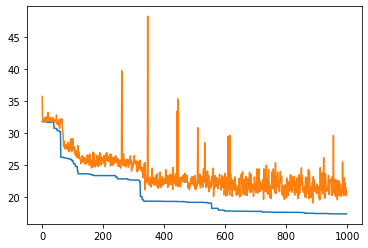

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(len(best_fitnesses_generation)), best_fitnesses_generation)
plt.plot(range(len(avg_fitnesses_generation)), avg_fitnesses_generation)

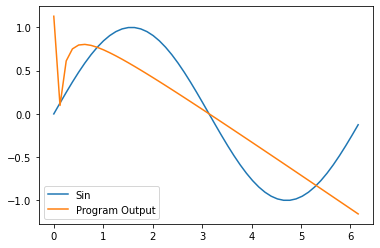

In [12]:
best_P = best_prog._clone()
outs   = []
for i in range(len(CASES)):
    best_P.reset()
    best_P._set_input(CASES[i])
    outs.append(best_P.execute())

plt.plot(CASES ,[math.sin(case) for case in CASES], label='Sin')
plt.plot(CASES, outs, label='Program Output')
plt.legend(loc='lower left')

In [4]:
best_prog

[-1.1532484191984638, -1.740499859809802, 0.0, -0.4984758223948882, 0.0, 0.1436734347165695, -4.824188267702662, -0.4984758223948882, 0.8333333333333333, 0.5, 0.5, -2.240499859809802, -0.4984758223948882, -0.4984758223948882, 0.0, -0.75, 0.6418633965536079, 0.4119886198353341, 0.0, 0.0, 0.5153237457007338, 0.0, 0.2863980824734801, -0.2, -1.0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 6.157521601035995]
Copy(27,1,13)
Add(25,27,1)
Sqrt(13,19,17)
Sub(30,13,13)
Mean(4,21,17)
Mean(5,19,17)
Mean(1,16,3)
Copy(28,21,12)
Mean(2,14,12)
Add(28,24,15)
Div(29,17,14)
Sub(25,13,6)
Mean(12,15,23)
Copy(20,15,21)
Add(23,24,20)
Mean(18,27,22)
Copy(24,26,0)
Sub(1,10,8)
Mul(28,4,14)
Sub(26,4,10)
Sqrt(28,9,0)
Mean(11,6,13)
Mul(12,22,5)
Sub(1,10,8)
Mul(2,19,12)
Sub(12,29,23)
Sqrt(13,17,3)
Sqrt(3,9,12)
Copy(26,0,9)
Div(12,22,1)
Mean(12,6,0)
Sub(3,18,7)
Sqrt(17,16,16)
Mean(12,6,0)
Sub(1,10,11)
Mean(1,6,0)

(0.0, 50.0)

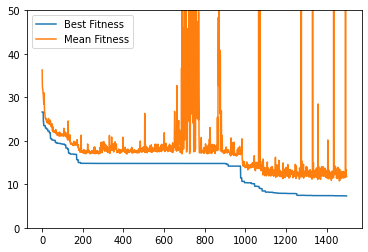

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(best_fitnesses_generation)), best_fitnesses_generation, label='Best Fitness')
plt.plot(range(len(avg_fitnesses_generation)), avg_fitnesses_generation, label='Mean Fitness')
plt.legend(loc='best')
plt.ylim(0, 50)

Text(0.5, 1.0, 'Sine Regression after 1500 Generations and 1000 Population Size')

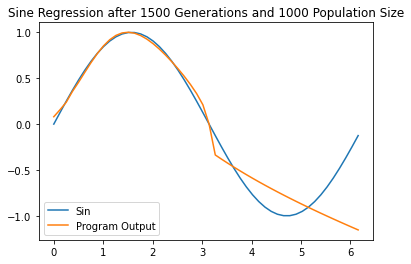

In [11]:
best_P = best_prog._clone()
outs   = []
for i in range(len(CASES)):
    best_P.reset()
    best_P._set_input(CASES[i])
    outs.append(best_P.execute())

plt.plot(CASES ,[math.sin(case) for case in CASES], label='Sin')
plt.plot(CASES, outs, label='Program Output')
plt.legend(loc='lower left')
plt.title('Sine Regression after 1500 Generations and 1000 Population Size')

In [32]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
dataF = load_breast_cancer(as_frame=True)['data']
data  = load_breast_cancer()['data']
target = load_breast_cancer()['target']

In [36]:
class_cases = np.append(data, target.reshape(-1,1), 1)
class_cases.shape

(569, 31)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test1, y_train, y_test1 = train_test_split(data, target, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test       = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)

In [39]:
from sklearn.metrics import roc_auc_score
def f3(program, cases=X_train):
    outs = []
    for row in range(len(X_train)):
        tv = y_train[row]           #true value of sin for the fitness case
        program.reset()             #return value of the program evaluated on the fitness case
        program._set_inputs(cases[row])
        rv = program.execute()
        outs.append(rv) 
    outs = [(float(i)-min(outs))/(max(outs)-min(outs)) for i in outs]
    fitness1 = roc_auc_score(y_train, outs)
        #fitness_1 += math.sqrt((rv-tv)**2)
    
    #     for out in outs:
    #         if out in out_counts.keys():
    #             out_counts[out] += 1
    #         else:
    #             out_counts[out] = 1
    #     for out_count in out_counts.keys():
    #         if out_counts[out_count] > 1:
    #             fitness_2 += out_counts[out_count]**2
    # fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 
    return fitness_1

In [47]:
POP_SIZE       = 1000
XOVER_P        = 0.009
ELITE_K        = int(POP_SIZE*0.1)#50
population     = [Program(reg_init='z', IS=['Add', 'Sub', 'Mul', 'Div', 'Mean', 'Copy', 'Sqrt', 'Sin', 'Max', 'Min','Sqr', 'Exp', 'Log' ]) for i in range(POP_SIZE)] # Start with a population of 500 random programs
best_fitness_c = 10**100                     # Start this very high since even a random program will beat it
best_prog_c    = None                       # Keep track of the best program
tolerance      = 1                          # Stop searching when the best program has a fitness less than 1 (we want to minimize error)
generation     = 1

best_fitnesses_generation_c = []
avg_fitnesses_generation_c  = []

#TODO: Consider a fitness function that encourages putting DIFFERENT functions of the input in different registers. 10_000
#      is too big for a population and XOVER and mutation probabilities should be lowered.



logfile = open('log4.txt', 'w+')

while (generation < 100):
    if (generation % 100 < 10):
        dumpfile='./saved_generations/generation'+str(generation)+'.pkl'
        with open(dumpfile, 'wb+') as du:
            pickle.dump(population, du)
    print('Generation: ', generation)
    this_gen_fitness= []
    for individual in population:
        ind_fit = f3(individual)
        this_gen_fitness_c.append(ind_fit)
        if ind_fit > best_fitness_c:
            print('----------NEW BEST FITNESS---------------')
            print(ind_fit)
            print(individual)
            best_fitness = ind_fit
            best_prog    = individual
    best_fitnesses_generation_c.append(max(this_gen_fitness_c))
    avg_fitnesses_generation_c.append(sum(this_gen_fitness_c)/len(this_gen_fitness_c))
    logfile.write('-----------------GENERATION ' + str(generation) + '---------------------------\n')
    logfile.write("Fitnesses: [" + ", ".join(str(item) for item in this_gen_fitness) + "]\n")
    logfile.write('best fitness: ' +  str(best_fitnesses_generation[-1]) + "\n")
    logfile.write('avg fitnesses: ' +  str(avg_fitnesses_generation[-1]) + "\n")
    print('Best Fitness: ', best_fitnesses_generation[-1])
    print('Avg  Fitness: ', avg_fitnesses_generation[-1])
    elite = Selection.elite_selection(population, f1, CASES, k=int(POP_SIZE/10), opt_max=True)
    tournament = Selection.tournament_selection(population, f1, CASES, next_gen_size=int((POP_SIZE*8)/10), opt_max=True)
    randos     = [Program(reg_init='z', IS=['Add', 'Sub', 'Mul', 'Div', 'Mean', 'Copy', 'Sqrt', 'Sin', 'Max', 'Min','Sqr', 'Exp', 'Log' ]) for i in range(int(POP_SIZE/10))]
    # while(len(next_gen) < POP_SIZE-(POP_SIZE/10)): #Fill the next gen with tournament selection up to 90%
    #     r1 = random.randint(0, POP_SIZE-1)
    #     r2 = random.randint(0, POP_SIZE-1)
    #     if this_gen_fitness[r1] < this_gen_fitness[r2]:
    #         next_gen.append(population[r1]._clone())
    #     else:
    #         next_gen.append(population[r2]._clone())
            
    # while(len(next_gen) < POP_SIZE):              #Fill the rest of the population with random programs
    #     next_gen.append(Program(reg_init='z'))
    next_gen=elite+tournament+randos
    for program in range(len(next_gen)):
        mut(next_gen[program])
        if random.random() < XOVER_P:
            program2 = random.randint(0, len(next_gen)-1)
            XOver(next_gen[program], next_gen[program2])
            logfile.write('Crossed ' + str(program) + ' and ' + str(program2) +'\n')
    generation += 1
    population = next_gen
    for program in population:
        program.reset()
    
            
logfile.close()

Generation:  1


AttributeError: 'Program' object has no attribute '_set_inputs'

In [46]:
%load_ext autoreload
%autoreload 2
from Program import Program